In [1]:
from __future__ import unicode_literals, print_function, division
from io import open

import pandas as pd

In [2]:
df = pd.read_csv('./data/skill_data.csv')
df['result'] = df['result'].fillna('lose')
all_categories = list(df['result'].unique())
category_lines = {}

for cate in all_categories:
    category_lines[cate] = []
    cate_list = list(df[df['result']==cate]['skills'])
    for s in cate_list:
        skills = s.split(",")
        skills = [s.split("_")[-1] for s in skills]
        category_lines[cate].append(skills)

In [3]:
df.groupby(['result'])['id'].count()

result
lose    81160
win      7688
Name: id, dtype: int64

In [4]:
all_categories = list(df['result'].unique())
category_lines = {}
n_categories = len(all_categories)

all_letters = []

for cate in all_categories:
    category_lines[cate] = []
    cate_list = list(df[df['result']==cate]['skills'])
    for s in cate_list:
        skills = s.split(",")
        skills = [s.split("_")[-1] for s in skills if s.split("_")[-1] != ""]
        
        all_letters += skills
        if cate == "win" and len(skills) <= 30:
            continue
        if cate == "lose" and len(skills) < 10:
            continue
        category_lines[cate].append(skills)
        
all_letters = list(set(all_letters))
n_letters = len(all_letters)

In [5]:
for cate in all_categories:
    print(cate, ": ", len(category_lines[cate]))

lose :  41104
win :  7272


# Define model structure

In [6]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


C:\Users\hungd\AppData\Local\Temp\ipykernel_14828\400433282.py:29: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Training

In [7]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [8]:
def resultTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputSkillTensor(line):
    tensor = torch.zeros(len(line)-1, 1, n_letters)
    for li in range(len(line)-1):
        letter = line[li]
        tensor[li][0][all_letters.index(letter)] = 1
    return tensor

def targetSkillTensor(line):
    letter_indexes = [all_letters.index(line[li]) for li in range(1, len(line))]
    return torch.LongTensor(letter_indexes)

In [9]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = resultTensor(category)
    input_line_tensor = inputSkillTensor(line)
    target_line_tensor = targetSkillTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [10]:
# cate, line = randomTrainingPair()
# print(resultTensor(cate))
# print(inputSkillTensor(line))
# print(targetSkillTensor(line))
randomTrainingExample()

(tensor([[0., 1.]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 1.,  ..., 0., 0., 0.]]]),
 tensor([14, 14,  9, 16,  8,  8,  9,  9, 16,  8, 14,  9,  8, 16,  9, 14,  8, 16,
         15, 21, 21,  6, 21, 18,  4,  2, 15, 24, 21,  6, 20, 21, 24, 24, 20, 15,
          6, 24,  4,  4,  4, 24,  2,  6,  4, 18, 20,  6,  2,  2]))

## Train network

In [11]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [12]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 21s (5000 5%) 3.0187
2m 39s (10000 10%) 2.2199
3m 58s (15000 15%) 3.2326
5m 20s (20000 20%) 3.0133
6m 38s (25000 25%) 2.9723
7m 54s (30000 30%) 2.7106
9m 12s (35000 35%) 2.7704
10m 26s (40000 40%) 2.9836
11m 38s (45000 45%) 3.0658
12m 51s (50000 50%) 3.1009
14m 8s (55000 55%) 3.3129
15m 21s (60000 60%) 2.8988
16m 35s (65000 65%) 2.8936
17m 48s (70000 70%) 3.0814
19m 1s (75000 75%) nan
20m 15s (80000 80%) nan
21m 31s (85000 85%) nan
22m 47s (90000 90%) nan
24m 10s (95000 95%) nan
25m 30s (100000 100%) nan


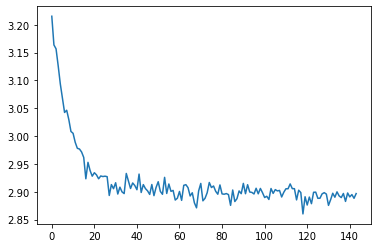

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [22]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = resultTensor(category)
        input = inputSkillTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter
        output, hidden = rnn(category_tensor, input[0], hidden)
        
        topv, topi = output.topk(3)
        return topv, topi

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [27]:
topv, topi = sample('win', ['Drill', 'Soundwave Field'])

In [29]:
topi

tensor([[0, 1, 2]])

In [26]:
all_letters

['Laser Beam',
 'Hammer',
 'Drill',
 'HE Fuel',
 'Rocket',
 'Horseshoe',
 'Black Hawk',
 'Whip',
 'Life Insurance',
 'Soundwave Field',
 'Guard Badge',
 'Captain Shield',
 'Wanted Poster',
 'Energy Drink',
 'Acid Bottle',
 'Captain Boot',
 'Revolver',
 'Ammo Thruster',
 'Pocket Watch',
 'Gold Molecule',
 'Hi-Power Magnet',
 'Power Gauntlet',
 'Lightsaber',
 'Shotgun',
 'Ronin Oyoroi',
 'White Eagle',
 'Energy Core']